## Introduction
My project aims to determine which factors predicted support for Donald Trump in the 2016 presidential primary.  I also want to compare these results to counties that supported Bernie Sanders.  I am looking at this data at the county scale, because that is the highest resolution at which most states release primary results.

I used several data sources.  I got topographic data from the US Census Bureau, as well as data about unemployment.  I got a summary of descriptive variables about each county from a [kaggle competition](https://www.kaggle.com/benhamner/2016-us-election).  Most of my features are from 2014, although some go further back to measure changes over time.

All of my inputs were continuous, and my target was a boolean indicating whether a county's support for the candidate exceeded the state-wide average.

I developed visualizations using Vincent.  My visualization functions are not in this file because I saved them in a separate [repository](https://github.com/alanjschoen/magamap).

I was able to build models that were predictive, and my preliminary results show that the demographics of Trump and Sanders supporters are very different.

In [216]:
import pandas as pd
import sys
sys.path.insert(0, '../magamap')
import vincent
from plot_tools import makeMap, mergeToMap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cross_validation as cv
%matplotlib inline
vincent.initialize_notebook()

In [217]:
# Load Primary Results
file_path = 'data/primary_results.csv'
df_geo_key = 'fips'
primary2014 = pd.read_csv(file_path)
primary2014.dropna(how='any', inplace=True)
primary2014['fips'] = primary2014['fips'].apply(lambda x: "%05d"%int(x))
#primary2014.head()

In [218]:
# Load unemployment
data_path = 'data/laucnty14.xlsx'
colnames = ['laus','stateFips','countyFips', 'name','year','NULL','laborForce','employed','unemployed','unemployedPercent']
unem2014 = pd.read_excel(data_path,na_values=[' '], names=colnames, skiprows=range(5), skip_footer=3)
unem2014['stateFips'] = unem2014['stateFips'].apply(lambda x: "%02d"%x)
unem2014['countyFips'] = unem2014['countyFips'].apply(lambda x: "%03d"%x)
unem2014.drop('NULL', axis=1, inplace=True)
unem2014['fips'] = unem2014['stateFips'].str.cat(unem2014['countyFips'])
df_geo_key = 'fips'
df_data_col = 'unemployedPercent'
# unem2014.head()

In [219]:
# Load County Facts
file_path = 'data/county_facts.csv'
df_geo_key = 'fips'
countyfacts = pd.read_csv(file_path)
countyfacts.dropna(how='any', inplace=True)
countyfacts['fips'] = countyfacts['fips'].apply(lambda x: "%05d"%int(x))
#countyfacts.head()

In [220]:
# Merge everything
merged = primary2014.merge(unem2014, how='inner', on='fips', copy=True)
merged = merged.merge(countyfacts, how='inner', on='fips', copy=True)
merged.head()

,state,state_abbreviation_x,county,fips,party,candidate,votes,fraction_votes,laus,stateFips,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,Alabama,AL,Autauga,01001,Democrat,Bernie Sanders,544,0.182,CN0100100000000,01,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
1,Alabama,AL,Autauga,01001,Democrat,Hillary Clinton,2387,0.800,CN0100100000000,01,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
2,Alabama,AL,Autauga,01001,Republican,Ben Carson,1764,0.146,CN0100100000000,01,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
3,Alabama,AL,Autauga,01001,Republican,Donald Trump,5387,0.445,CN0100100000000,01,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
4,Alabama,AL,Autauga,01001,Republican,John Kasich,421,0.035,CN0100100000000,01,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8


## Map of trump support

In [221]:
# plot trump results
trump = merged[merged['candidate'] == 'Donald Trump']
vis = makeMap(trump, 'fips', 'fraction_votes', 'county')
vis.scales['color'].domain = [0, 1]
vis.legend(title='Fraction of votes for Trump')
vis.display()
print min(trump['fraction_votes']), max(trump['fraction_votes'])

0.0 0.915


We're missing a few states because they don't use counties for their primaries, so I couldn't merge them with the county map.  Another thing I noticed on this map is that some states are very red.  This roughly corresponds with the states that voted later in the year.  These states voted overwhelmingly for Trump because he was the clear winner.  Generally, there is a strong correlation between counties in a state, so I wanted to normalize the data by state.

## Creating the target variable

I normalized each county by subtracting the average Trump support for the state.  Then I created a boolean feature to indicate whether each county was above the state average and plotted it on a map.  I repeated this analysis for Bernie Sanders.

In [222]:
# aprStates = set(['WI','NY','CT','DE','MD','PA','RI'])
# mayStates = set(['IN','NB','WV','OR','WA'])
# junStates = set(['CA','MO','NJ','NM','SD'])

# trump = merged[merged['candidate'] == 'Donald Trump']
# trump = trump[~trump['state_abbreviation_x'].isin(mayStates)]
# trump = trump[~trump['state_abbreviation_x'].isin(junStates)]

# vis = makeMap(trump, 'fips', 'fraction_votes', 'county')
# vis.scales['color'].domain = [0, 1]
# vis.legend(title='Fraction of votes for Trump')
# vis.display()
# print min(trump['fraction_votes']), max(trump['fraction_votes'])

In [223]:
# Normalize vote totals by state
from plot_tools import makeMap, mergeToMap
df = merged.copy()
demean = lambda df: df - df.mean()
demeaned = merged.groupby(['state_abbreviation_x', 'candidate'])['fraction_votes'].transform(demean)
df = df.assign(demeanded=demeaned)

trump = df[df['candidate'] == 'Donald Trump']
kasich = df[df['candidate'] == 'John Kasich']
lizard = df[df['candidate'] == 'Ted Cruz']
bernie = df[df['candidate'] == 'Bernie Sanders']
hillary = df[df['candidate'] == 'Hillary Clinton']

trump = trump.assign(won=((trump['demeanded'] > 0).astype(int)))
bernie = bernie.assign(won=((bernie['demeanded'] > 0).astype(int)))

print "Trump support map"
vis = makeMap(trump, 'fips', 'won', 'county')
vis.scales['color'].domain = [0, 1]
vis.legend(title='Trump beat state average')
vis.display()

print "Sanders support map"
vis = makeMap(bernie, 'fips', 'won', 'county', 'PuBu')
vis.scales['color'].domain = [0, 1]
vis.legend(title='Bernie beat state average')
vis.display()

Trump support map


Sanders support map


I normalized the states by subtracting the mean for each candidate.  This isn't necessarily the best way to do it, because some states were legitimate landslides.  Texas, for example voted overwhelmingly for Ted Cruz, who is from Texas.  So it's probably not right to normalize Texas by it's mean.  There may be a better way to divide the distributions of vote outcomes, but that's beyond the scope of the MVP.  I may need to redefine the target variable.

## Training models

I decided to start with a logistic regression with l2 regularization.  I wanted to use the coefficients as a kind of correlation, so I picked L2 rather than L1, which would have eliminated co-dependent variables.

          Train, Test
Accuracy: 0.696, 0.677
AUC:      0.763, 0.744
F1:       0.733, 0.660


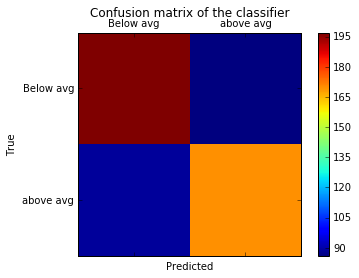

In [224]:
# Split training and test

df = trump.copy()
y = df['won']
xfeatures = df.columns[13:17]|df.columns[19:-2]
X = df[xfeatures]

x_train, x_test, y_train, y_test = cv.train_test_split(X,y,test_size=0.2,random_state=1234)

from sklearn.preprocessing import normalize
x_train = normalize(x_train, norm='l2', axis=0, copy=True)
x_test = normalize(x_test, norm='l2', axis=0, copy=True)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
lr = LogisticRegression(C=10)

result = lr.fit(x_train, y_train)
print "          Train, Test"
print "Accuracy: %.3f, %.3f"%(result.score(x_train, y_train), result.score(x_test, y_test))
print "AUC:      %.3f, %.3f"%(roc_auc_score(y_train, lr.predict_proba(x_train)[:,1]), roc_auc_score(y_test, lr.predict_proba(x_test)[:,1]))
print "F1:       %.3f, %.3f"%(f1_score(y_train,lr.predict(x_train)), f1_score(y_test,lr.predict(x_test)))

from sklearn.metrics import confusion_matrix
cm =  confusion_matrix(y_test, lr.predict(x_test))
labels=['Below avg', 'above avg']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The results show that this model is predictive, so I looked into the coefficients to see which features were important.  I see that education is negatively correlation, as is the percentage change in population, and the number of people living in multi-unit houses.  I would summarize the indicators as education, economy, urbanization, and age.  The racial makeup of the county did not appear predictive at all.

In [225]:
# Load variable descriptions
facts_desc = pd.read_csv('data/county_facts_dictionary.csv', header=0)
vardesc = facts_desc.set_index('column_name').to_dict()['description']

print "Features, by absolute weight in logistic regression with l2 regularization"
for (score, feat) in sorted(zip(lr.coef_[0], xfeatures), key=lambda x: abs(x[0]))[::-1]:
    if feat in vardesc:
        feat = vardesc[feat]
    print "%.3f: %s"%(score, feat)

Features, by absolute weight in logistic regression with l2 regularization
-15.333: Bachelor's degree or higher, percent of persons age 25+, 2009-2013
-13.945: Population, percent change - April 1, 2010 to July 1, 2014
-11.335: Housing units in multi-unit structures, percent, 2009-2013
10.202: unemployedPercent
7.907: Persons 65 years and over, percent, 2014
6.711: Persons below poverty level, percent, 2009-2013
-5.900: Median household income, 2009-2013
-5.540: Manufacturers shipments, 2007 ($1,000)
5.152: American Indian and Alaska Native alone, percent, 2014
-4.427: Per capita money income in past 12 months (2013 dollars), 2009-2013
4.335: Mean travel time to work (minutes), workers age 16+, 2009-2013
4.285: Land area in square miles, 2010
-3.320: Private nonfarm employment,  2013
-3.218: Asian alone, percent, 2014
-3.084: Building permits, 2014
-2.851: Retail sales per capita, 2007
-2.634: American Indian- and Alaska Native-owned firms, percent, 2007
2.624: unemployed
-2.475: Perso

I also tried restricting the variables to see if I could build a good model with only a few parameters.  Using the 5 highest ranked parameters, I got worse training accuracy but beter test accuracy.

In [226]:
# Restrict variables
goodvars = (abs(lr.coef_) > 5)[0]
print np.sum(goodvars)

print [f for (i,f) in enumerate(xfeatures) if goodvars[i]]

x_train = x_train[:,goodvars]
x_test = x_test[:,goodvars]

lr = LogisticRegression(C=10)
result = lr.fit(x_train, y_train)
print "          Train, Test"
print "Accuracy: %.3f, %.3f"%(result.score(x_train, y_train), result.score(x_test, y_test))
print "AUC:      %.3f, %.3f"%(roc_auc_score(y_train, lr.predict_proba(x_train)[:,1]), roc_auc_score(y_test, lr.predict_proba(x_test)[:,1]))
print "F1:       %.3f, %.3f"%(f1_score(y_train,lr.predict(x_train)), f1_score(y_test,lr.predict(x_test)))

9
['AGE775214', 'EDU685213', 'HSG096213', 'INC110213', 'MAN450207', 'PST120214', 'PVY020213', 'RHI325214', 'unemployedPercent']
          Train, Test
Accuracy: 0.690, 0.679
AUC:      0.758, 0.740
F1:       0.728, 0.685


## Bernie
I repeated the analysis with bernie sanders.  Again, the model is predictive, but the model is very different.  Racial predictors rank near the top, with whiteness predicting Bernie support.  The correlation with education and age is completely reversed.  Many economic indicators are positively correlated.  On the county level, Bernie's supporters do not look similar to Trump's supporters at all.

In [227]:
# Split training and test

df = bernie.copy()
y = df['won']
xfeatures = df.columns[13:17]|df.columns[19:-2]
X = df[xfeatures]

x_train, x_test, y_train, y_test = cv.train_test_split(X,y,test_size=0.2,random_state=1234)

from sklearn.preprocessing import normalize
x_train = normalize(x_train, norm='l2', axis=0, copy=True)
x_test = normalize(x_test, norm='l2', axis=0, copy=True)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
lr = LogisticRegression(C=10)

result = lr.fit(x_train, y_train)
print "          Train, Test"
print "Accuracy: %.3f, %.3f"%(result.score(x_train, y_train), result.score(x_test, y_test))
print "AUC:      %.3f, %.3f"%(roc_auc_score(y_train, lr.predict_proba(x_train)[:,1]), roc_auc_score(y_test, lr.predict_proba(x_test)[:,1]))
print "F1:       %.3f, %.3f"%(f1_score(y_train,lr.predict(x_train)), f1_score(y_test,lr.predict(x_test)))

# Load variable descriptions
facts_desc = pd.read_csv('data/county_facts_dictionary.csv', header=0)
vardesc = facts_desc.set_index('column_name').to_dict()['description']

print "Features, by absolute weight in logistic regression with l2 regularization"
for (score, feat) in sorted(zip(lr.coef_[0], xfeatures), key=lambda x: abs(x[0]))[::-1]:
    if feat in vardesc:
        feat = vardesc[feat]
    print "%.3f: %s"%(score, feat)


          Train, Test
Accuracy: 0.646, 0.634
AUC:      0.708, 0.692
F1:       0.685, 0.666
Features, by absolute weight in logistic regression with l2 regularization
-18.118: Black or African American alone, percent, 2014
9.438: Population, percent change - April 1, 2010 to July 1, 2014
8.214: Bachelor's degree or higher, percent of persons age 25+, 2009-2013
-6.669: Black-owned firms, percent, 2007
-6.271: Hispanic-owned firms, percent, 2007
4.428: Building permits, 2014
4.312: White alone, not Hispanic or Latino, percent, 2014
4.156: Median value of owner-occupied housing units, 2009-2013
-3.873: Persons 65 years and over, percent, 2014
3.473: White alone, percent, 2014
3.036: Two or More Races, percent, 2014
2.715: Retail sales per capita, 2007
-2.641: Hispanic or Latino, percent, 2014
-2.578: Language other than English spoken at home, pct age 5+, 2009-2013
2.577: American Indian and Alaska Native alone, percent, 2014
-2.282: Asian-owned firms, percent, 2007
-2.242: unemployedPerce

## Conclusion
In conclusion, I was able to build predictive models for Trump support and Sanders support, and I found that the two models are very different.